In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import OffManifoldLearning.globals as gl

plt.style.use('default')

In [2]:
dataset = ['stroke', 'intact']
tinfo = pd.read_csv('../data/baseline/tinfo.tsv', sep='\t')
medianB = tinfo[tinfo.group=='stroke'].w_b.median()
tinfo['severity'] = 'mild'
tinfo.loc[tinfo.w_b < medianB, 'severity'] = 'severe'
N = len(tinfo.subj_id.unique())

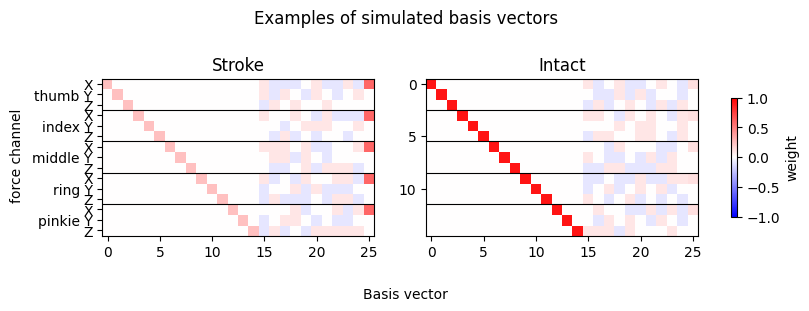

In [3]:
sn = 105
A_i = np.load(f'../data/baseline/basis_vectors.intact.{sn}.npy')
A_s = np.load(f'../data/baseline/basis_vectors.stroke.{sn}.npy')

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 3])
axs[1].imshow(A_i, vmin=-1, vmax=1, cmap='bwr')
axs[0].imshow(A_s, vmin=-1, vmax=1, cmap='bwr')
axs[0].set_title('Stroke')
axs[1].set_title('Intact')
axs[0].set_yticks(np.arange(0, A_i.shape[0]))
axs[0].set_yticklabels(gl.channels)
for ax in axs:
    for i in [2.5, 5.5, 8.5, 11.5]:
        ax.axhline(i, color='k', lw=.8)

cax = axs[0].get_images()[0]
cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.01)
cbar.set_label('weight')

fig.supxlabel('Basis vector', fontsize=10)
fig.supylabel('force channel', fontsize=10)

fig.suptitle('Examples of simulated basis vectors')

plt.show()

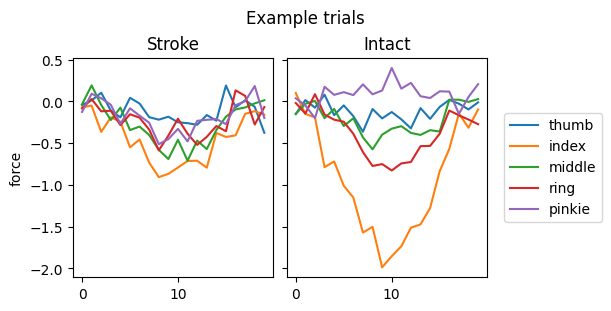

In [141]:
X_i = np.load(f'../data/baseline/single_finger.pretraining.intact.{sn}.npy')
X_s = np.load(f'../data/baseline/single_finger.pretraining.stroke.{sn}.npy')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])
tr = 6
axs[0].plot(X_s[tr, ::5, ::3])
axs[1].plot(X_i[tr, ::5, ::3])
axs[0].set_ylabel('force')
axs[0].set_title('Stroke')
axs[1].set_title('Intact')
axs[1].legend(['thumb', 'index', 'middle', 'ring', 'pinkie'], bbox_to_anchor=(1.05, .5), loc='center left')
fig.suptitle('Example trials')
plt.show()

In [142]:
euc = np.zeros((2, N, 5, 6, 6)) # (groups, n_subj, n_finger, dir, dir)
cos = np.zeros_like(euc)
for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        for s, sn in enumerate(tinfo.subj_id.unique()):
            tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == ds)]
            X = np.load(f'../data/baseline/single_finger.pretraining.{ds}.{sn}.npy') # (trials, time, channels)
            X_f = X[tinfo_s.finger == f, 50] #.mean(axis=1)
            X_m = X_f.reshape(6, -1, 15).mean(axis=1)
            G = X_m @ X_m.T
            diag = np.diag(G)
            norm = np.sqrt(np.outer(diag, diag))
            D2 = diag[:, None] + diag[None, :] - 2 * G
            euc[d, s, f] = np.sqrt(D2)
            cos[d, s, f] = 1 - G / norm

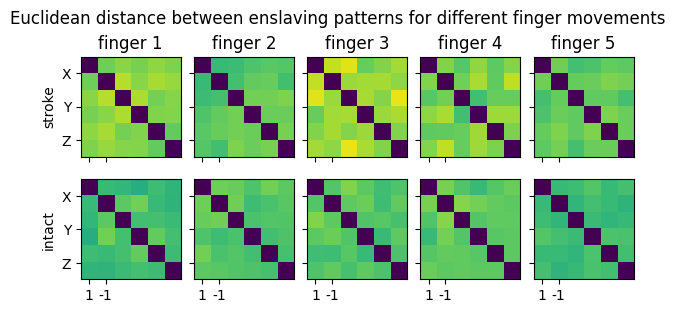

In [143]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])

for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        ax = axs[d, f]
        ax.imshow(euc[d, :, f].mean(axis=0), vmin=0, vmax=.5)
        ax.set_title(f'finger {fi + 1}') if d == 0 else None
        ax.set_yticks([0.5, 2.5, 4.5])
        ax.set_yticklabels(['X', 'Y', 'Z'])
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['1', '-1'])
        ax.set_ylabel(ds) if f == 0 else None

fig.suptitle('Euclidean distance between enslaving patterns for different finger movements')

plt.show()

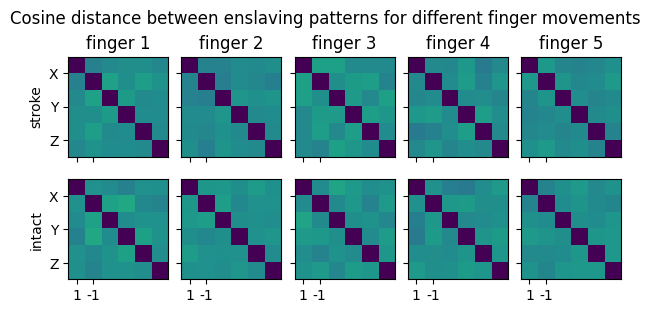

In [144]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])

for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        ax = axs[d, f]
        ax.imshow(cos[d, :, f].mean(axis=0), vmin=0, vmax=2)
        ax.set_title(f'finger {fi + 1}') if d == 0 else None
        ax.set_yticks([0.5, 2.5, 4.5])
        ax.set_yticklabels(['X', 'Y', 'Z'])
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['1', '-1'])
        ax.set_ylabel(ds) if f == 0 else None

fig.suptitle('Cosine distance between enslaving patterns for different finger movements')

plt.show()

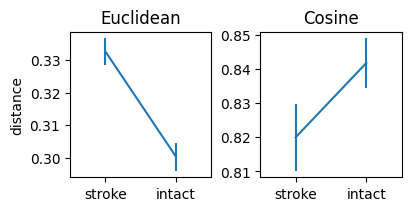

In [145]:
tinfo_g = tinfo.groupby(['subj_id', 'group', 'severity']).mean(numeric_only=True).reset_index()
w_b_s = tinfo_g[tinfo_g['group'] == 'stroke'].w_b.to_numpy()
w_b_i = tinfo_g[tinfo_g['group'] == 'intact'].w_b.to_numpy()

euc_p = euc.mean(axis=(2, 3, 4))
euc_avg = euc_p.mean(axis=1)
euc_err = euc_p.std(axis=1) / np.sqrt(N)
cos_p = cos.mean(axis=(2, 3, 4))
cos_avg = cos_p.mean(axis=1)
cos_err = cos_p.std(axis=1) / np.sqrt(N)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=[4, 2], sharex=True)

axs[0].errorbar(dataset, euc_avg, yerr=euc_err)
axs[0].set_title('Euclidean')
axs[0].set_ylabel('distance')
axs[1].errorbar(dataset, cos_avg, yerr=cos_err)
axs[1].set_xlim(-.5, 1.5)
axs[1].set_title('Cosine')

plt.show()

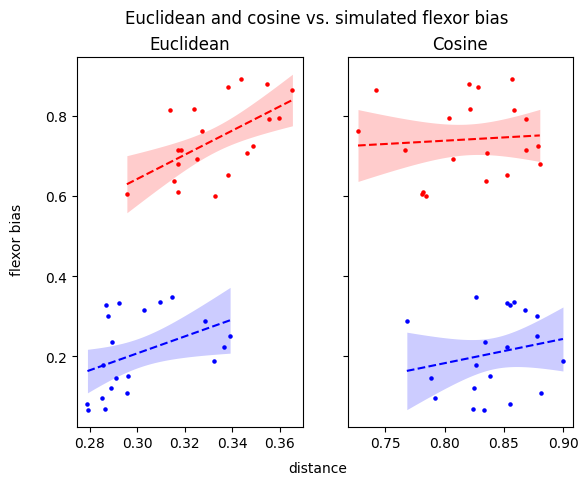

In [146]:
from scipy.stats import t, linregress

fig, axs = plt.subplots(1, 2, sharey=True)

dist = np.vstack([euc_p, cos_p])
w_b = np.vstack([w_b_s, w_b_i])
color = ['r', 'b']
title = ['Euclidean', 'Cosine']
for p in range(dist.shape[0]):
    ax = axs[p // 2]
    x = dist[p]
    y =  w_b[p % 2]
    c = color[p % 2]
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = slope * x_fit + intercept

    # Compute confidence intervals
    n = len(x)
    y_pred = slope * x + intercept
    residuals = y - y_pred
    dof = n - 2
    t_val = t.ppf(0.95, dof)

    se_line = np.sqrt(np.sum(residuals ** 2) / dof * (1 / n + (x_fit - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)))
    ci = t_val * se_line

    # Check confidence interval at x = 0
    ix_0 = np.argmin(np.abs(x_fit - 0))
    lower_bound = y_fit[ix_0] - ci[ix_0]
    upper_bound = y_fit[ix_0] + ci[ix_0]

    ax.plot(x_fit, y_fit, color=c, linestyle='--', label='Fit')
    ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color=c, alpha=.2, label='95% CI', lw=0)
    ax.scatter(x, y, color=c, s=5)
    
axs[0].set_title('Euclidean')
axs[1].set_title('Cosine')

fig.supxlabel('distance', fontsize=10)
fig.supylabel('flexor bias', fontsize=10)

fig.suptitle('Euclidean and cosine vs. simulated flexor bias')

plt.show()


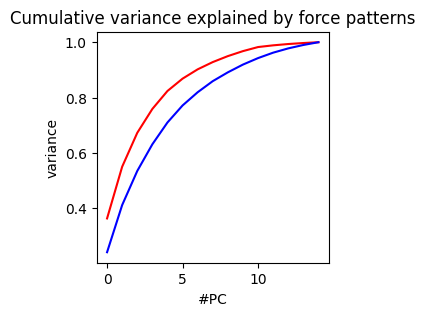

In [147]:
scaler = StandardScaler()
pca = PCA()
var_expl = np.zeros((2, N, 15)) # (groups, n_subj, n_channels)
for d, ds in enumerate(dataset):
    for s, sn in enumerate(tinfo.subj_id.unique()):
        tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == ds)]
        X = np.load(f'../data/baseline/single_finger.pretraining.{ds}.{sn}.npy') # (trials, time, channels)
        X_r = X.reshape(-1, X.shape[-1])
        X_norm = scaler.fit_transform(X_r)
        pca.fit(X_norm)
        var_expl[d, s] = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(np.cumsum(var_expl[0].mean(axis=0)), color='r', label='stroke')
ax.plot(np.cumsum(var_expl[1].mean(axis=0)), color='b', label='intact')
ax.set_title('Cumulative variance explained by force patterns')
ax.set_xlabel('#PC')
ax.set_ylabel('variance')

plt.show()